In [3]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
from shapely.geometry import box
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import scipy.io
import pandas as pd
import h5py
import xarray 

from constants import *

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir(homedir)


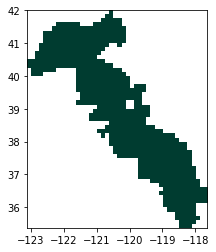

In [9]:

## bring in sierra nevada range
filepath = '/users/marianne/documents/data/watershed_masks/'
files = os.listdir(filepath)
tmp_list=[]
for f in files:
    try:
        mask = h5py.File(filepath + f)
        name = f.split('_watershed')[0]
        outline = mask[name+'_watershed_outline_coords']
        points = gpd.points_from_xy(outline['x'][0],outline['y'][0])
        poly = Polygon(points)
        # use the feature loop in case your polygon is a multipolygon
        features = [i for i in range(1)]
        tmp_list.append({'geometry': [poly]})
    except:
        continue

gdf = gpd.GeoDataFrame(tmp_list,crs=4326)

file = os.listdir(home_dir+"watershed_bounds/")
path = [os.path.join(home_dir+"watershed_bounds", i) for i in file if ".shp" in i]

gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path], 
                        ignore_index=True), crs=gpd.read_file(path[0]).crs)


envgdf = gdf #gpd.GeoDataFrame(gdf)

files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])
pe = rxr.open_rasterio(f,decode_times=False)
sj_geom = envgdf.to_crs(pe.rio.crs)

from rasterio.plot import plotting_extent
#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*envgdf.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
pe_clip = pe.rio.clip(crop_bound_box, crs=envgdf.crs,
                                    # Include all pixels even partial pixels
                                    all_touched=True,
                                    from_disk=True).squeeze()


pe_ext = plotting_extent(pe_clip,
                            pe_clip.rio.transform())



import matplotlib
cols = cm.get_cmap('BrBG', 256)
newcolors = cols(np.linspace(0, 1.5, 256))
white = np.array([1,1,1,0])
newcolors[:1, :] = white
newcmp = matplotlib.colors.ListedColormap(newcolors)

fig,ax=plt.subplots()
# Plotting Bounds Clip
maxval=np.nanmax(pe_clip.values)
pe_clip = pe.rio.clip(sj_geom.geometry,
                    all_touched=True,
                    from_disk=True)
ax.imshow(pe_clip[0,:,:],
            extent=pe_ext,
            #cbar=True, 
            cmap = newcmp,
            # title = '2016-09-09',
            )#vmin=2e-5, vmax=maxval)


In [67]:
re_dir = '/users/marianne/documents/data/reanalysis/'
dailyswe = np.load(re_dir+'daily_swe_avg.npy', allow_pickle=True)
maxday = np.load(re_dir + 'max_day.npy', allow_pickle=True)
maxswe = np.load(re_dir + 'max_swe.npy', allow_pickle=True)

h5_dir = '/users/marianne/documents/data/reanalysis/h5/'
for yr in range(1985 , 1986):
    hf = h5py.File(h5_dir + 'SN_SWE_WY'+ str(yr) + '.h5', 'r')
    swe = hf.get('SWE')
    day = maxday[yr-1985]
    swe_tmp = swe[day,:,:].astype('float')
    swe_tmp[swe_tmp<0]=np.nan

In [115]:
os.chdir('/users/marianne/documents/pe_snow_fires/')
files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])
pe = rxr.open_rasterio(f,decode_times=False)


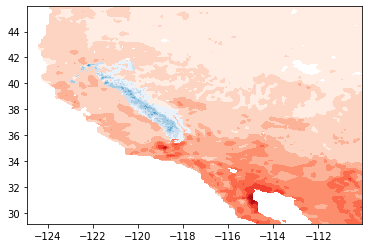

In [114]:
lon = [i[0] for i in hf.get('lon').value]
lat = [i for i in hf.get('lat').value[0]]
geometry = [Point(xy) for xy in zip(lon,lat)]

x_, y_ = np.meshgrid(lat, lon)
z_grid = np.array(swe_tmp)# .reshape(len(lat),len(lon))

x,y = np.meshgrid(pe['x'],pe['y'])
z = pe.values[0,:,:]
z[z<0]=np.nan
fig,ax=plt.subplots()
ax.contourf(x,y,z,cmap='Reds')
ax.contourf(y_,x_,z_grid,cmap='Blues')
plt.show()

In [140]:
swe_da = xr.DataArray(
    data=z_grid,
    dims=["x", "y"],
    coords=dict(
        lon=(["x", "y"], x_),
        lat=(["x", "y"], y_),
    ),
    attrs=dict(
        description="snow water equivalent.",
        units="mm",
    ),
)
swe_da

<xarray.DataArray (x: 5701, y: 6601)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (x, y) float64 42.0 42.0 42.0 42.0 42.0 ... 35.4 35.4 35.4 35.4
    lat      (x, y) float64 -123.3 -123.3 -123.3 -123.3 ... -117.6 -117.6 -117.6
Dimensions without coordinates: x, y
Attributes:
    description:  snow water equivalent.
    units:        mm

In [224]:
swe_lon = swe_da.lon[0,:]
swe_lat = swe_da.lat[:,0]
pe_lat = pe_da.lon[0,:]
pe_lon = pe_da.lat[:,0]
pe = pe_da.values
pe_avg = np.zeros((6601,5701))
# 6601, 5701
for x in range(6601):
    for y in range(5701):
#for x in range(1000,1001):
#    for y in range(3000,3003):
        swe = swe_da.values[x,y]
        lat = swe_lat[x]
        lon = swe_lon[y]
        t_lon =np.where(np.abs(pe_lon-lon)<.1)
        t_lat = np.where(np.abs(pe_lat-lat)<.1)
        pe_avg[x,y] = np.nanmean(pe[t_lon,t_lat])

In [ ]:
plt.imshow(pe_avg)

array([[          nan,           nan,           nan, ..., 8.8030021e-07,
        2.2873519e-06, 3.6249637e-06],
       [          nan,           nan,           nan, ..., 2.8610771e-06,
        3.1553050e-06, 3.4132618e-06],
       [          nan,           nan,           nan, ..., 3.2898793e-06,
        3.0943254e-06, 2.5604745e-06],
       ...,
       [          nan,           nan,           nan, ..., 3.3392986e-05,
        2.3797524e-05, 2.4622517e-05],
       [          nan,           nan,           nan, ..., 3.3310916e-05,
        3.3196517e-05, 2.4130242e-05],
       [          nan,           nan,           nan, ..., 3.3494158e-05,
        3.3335258e-05, 3.5471476e-05]], dtype=float32)

In [137]:
pe_da = xr.DataArray(
    data=z,
    dims=["x", "y"],
    coords=dict(
        lon=(["x", "y"], x),
        lat=(["x", "y"], y),
    ),
    attrs=dict(
        description="potential evap.",
        units="sth",
    ),
)
swe_da.rio.write_crs('epsg:4326')
pe_da.rio.write_crs('epsg:4326')

<xarray.DataArray (x: 135, y: 120)>
array([[          nan,           nan,           nan, ..., 8.8030021e-07,
        2.2873519e-06, 3.6249637e-06],
       [          nan,           nan,           nan, ..., 2.8610771e-06,
        3.1553050e-06, 3.4132618e-06],
       [          nan,           nan,           nan, ..., 3.2898793e-06,
        3.0943254e-06, 2.5604745e-06],
       ...,
       [          nan,           nan,           nan, ..., 3.3392986e-05,
        2.3797524e-05, 2.4622517e-05],
       [          nan,           nan,           nan, ..., 3.3310916e-05,
        3.3196517e-05, 2.4130242e-05],
       [          nan,           nan,           nan, ..., 3.3494158e-05,
        3.3335258e-05, 3.5471476e-05]], dtype=float32)
Coordinates:
    lon          (x, y) float64 -124.9 -124.8 -124.7 ... -110.3 -110.2 -110.1
    lat          (x, y) float64 45.94 45.94 45.94 45.94 ... 29.19 29.19 29.19
    spatial_ref  int32 0
Dimensions without coordinates: x, y
Attributes:
    description:   potential evap.
    units:         sth
    grid_mapping:  spatial_ref

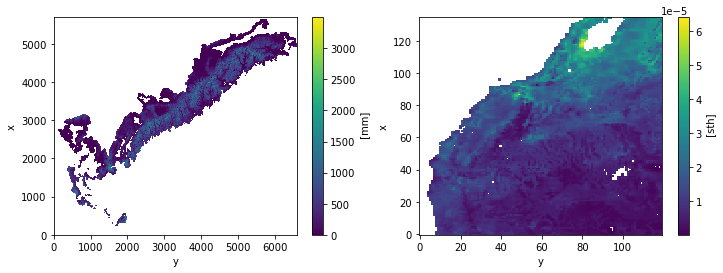

In [141]:
xds = xr.DataArray(swe_da)
xds_match = xr.DataArray(pe_da)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
xds.plot(ax=axes[0])
xds_match.plot(ax=axes[1])
plt.draw()

In [166]:
xds_match.rio.write_crs('epsg:4326')

<xarray.DataArray (x: 135, y: 120)>
array([[          nan,           nan,           nan, ..., 8.8030021e-07,
        2.2873519e-06, 3.6249637e-06],
       [          nan,           nan,           nan, ..., 2.8610771e-06,
        3.1553050e-06, 3.4132618e-06],
       [          nan,           nan,           nan, ..., 3.2898793e-06,
        3.0943254e-06, 2.5604745e-06],
       ...,
       [          nan,           nan,           nan, ..., 3.3392986e-05,
        2.3797524e-05, 2.4622517e-05],
       [          nan,           nan,           nan, ..., 3.3310916e-05,
        3.3196517e-05, 2.4130242e-05],
       [          nan,           nan,           nan, ..., 3.3494158e-05,
        3.3335258e-05, 3.5471476e-05]], dtype=float32)
Coordinates:
    lon          (x, y) float64 -124.9 -124.8 -124.7 ... -110.3 -110.2 -110.1
    lat          (x, y) float64 45.94 45.94 45.94 45.94 ... 29.19 29.19 29.19
    spatial_ref  int32 0
Dimensions without coordinates: x, y
Attributes:
    description:   potential evap.
    units:         sth
    grid_mapping:  spatial_ref

In [150]:
swe_da = swe_da.transpose('y','x')

swe_da.rio.to_raster("swe.tif")

import rasterio 
from rasterio.enums import Resampling
resample_factor = 0.5 # >1: upsample, <1: downsample

with rasterio.open("swe.tif") as dataset:
    imgdata = dataset.read(out_shape=(dataset.count,
                    int(dataset.height * resample_factor),
                    int(dataset.width * resample_factor)),
                resampling=Resampling.bilinear)

    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / imgdata.shape[-1]),
        (dataset.height / imgdata.shape[-2]))

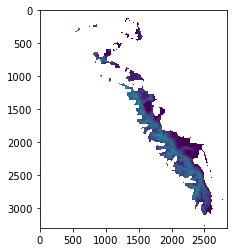

In [171]:
plt.imshow(imgdata[0,:,:])
plt.show()